In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [2]:
!ls ./out && ls ./data

bus_id_encoder.pickle	   cleaned_train.csv  output.csv
busstop_id_encoder.pickle  output1.csv	      route_id_encoder.pickle
routes.csv  sample_submission.csv  stops.csv  test.csv	training.csv


In [3]:
bus_id_encoder     = pickle.load(open("./out/bus_id_encoder.pickle"    , "rb"))
route_id_encoder   = pickle.load(open("./out/route_id_encoder.pickle"  , "rb"))
busstop_id_encoder = pickle.load(open("./out/busstop_id_encoder.pickle", "rb"))

In [4]:
dummy_buses = [325819008, 451509115]
print("bus ids", dummy_buses)
print("bus categorical ids", bus_id_encoder.transform(dummy_buses))

dummy_routes = [11100010, 11100012]
print("route ids", dummy_routes)
print("route categorical ids", route_id_encoder.transform(dummy_routes))

dummy_busstops = [388, 112]
print("busstop ids", dummy_busstops)
print("busstop categorical ids", busstop_id_encoder.transform(dummy_busstops))


bus ids [325819008, 451509115]
bus categorical ids [578 664]
route ids [11100010, 11100012]
route categorical ids [3 4]
busstop ids [388, 112]
busstop categorical ids [387 111]


In [5]:
dataset_df  = pd.read_csv("./out/cleaned_train.csv")

In [6]:
dataset_df

,DAY_OF_WEEK,HOUR_OF_DAY,MINUTE_OF_HOUR,SECOND_OF_MINUTE,TIME,BUS_ID,BUSROUTE_ID,BUSSTOP_ID,TIMESTAMP_DIFF
0,0,7,28,25,5305,0,3,17,117.0
1,0,7,30,22,5422,0,3,10,123.0
2,0,7,32,25,5545,0,3,8,121.0
3,0,7,34,26,5666,0,3,5,136.0
4,0,7,36,42,5802,0,3,3,174.0
...,...,...,...,...,...,...,...,...,...
3113890,4,21,47,30,56850,1076,8,109,74.0
3113891,4,21,48,44,56924,1076,8,117,123.0
3113892,4,21,50,47,57047,1076,8,119,91.0
3113893,4,21,52,18,57138,1076,8,121,82.0


In [11]:
dataset_input = dataset_df[['DAY_OF_WEEK', 'HOUR_OF_DAY', 'MINUTE_OF_HOUR', 'BUS_ID', 'BUSROUTE_ID', 'BUSSTOP_ID']]
dataset_label = dataset_df[['TIMESTAMP_DIFF']]

In [17]:
#del xgb_model
xgb_model = xgb.XGBRegressor(
    n_estimators     = 1000, 
    learning_rate    = 0.01, 
    #gamma            = 0, 
    #subsample        = 0.75,
    #colsample_bytree = 1, 
    max_depth        = 7
)

In [18]:
%time xgb_model.fit(dataset_input, dataset_label, early_stopping_rounds=10, verbose=True)

CPU times: user 1h 37min 9s, sys: 16.7 s, total: 1h 37min 26s
Wall time: 30min 49s


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

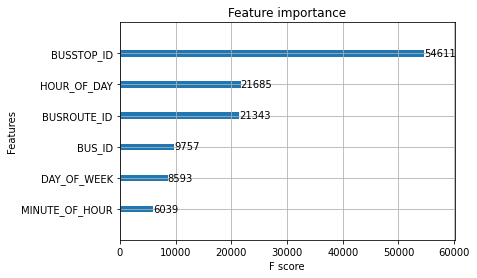

In [19]:
xgb.plot_importance(xgb_model)

In [20]:
xgb_model.score(dataset_input, dataset_label)

0.47740627284501935

In [22]:
predictions = xgb_model.predict(dataset_input)
mean_absolute_error(predictions, dataset_label)

56.03350804563506

In [ ]:
test_df = pd.read_csv("./data/test.csv")

In [ ]:
test_df

In [ ]:
test_df['DAY_OF_WEEK'     ] = pd.to_datetime(test_df['RECORD_DATE']).dt.dayofweek
test_df['HOUR_OF_DAY'     ] = pd.to_datetime(test_df['RECORD_DATE']).dt.hour
test_df['MINUTE_OF_HOUR'  ] = pd.to_datetime(test_df['RECORD_DATE']).dt.minute
test_df['SECOND_OF_MINUTE'] = pd.to_datetime(test_df['RECORD_DATE']).dt.second

In [ ]:
test_df

In [ ]:
import random

cleaned_buses = dataset_df['BUS_ID'].unique()

In [ ]:
dataset_input.iloc[0].values.tolist()

In [ ]:
# 'DAY_OF_WEEK', 'HOUR_OF_DAY', 'MINUTE_OF_HOUR', 'SECOND_OF_MINUTE', 'BUS_ID', 'BUSROUTE_ID', 'BUSSTOP_ID'
for idx, row in test_df.iterrows():
    if (pd.isna(row['TIMESTAMP'])):
        timestamp = test_df.iloc[idx-1]['TIMESTAMP']
        prev_row  = test_df.iloc[idx-1]
        if (not pd.isna(timestamp)):
            day_of_week      = prev_row['DAY_OF_WEEK']
            hour_of_day      = prev_row['HOUR_OF_DAY']
            minute_of_hour   = prev_row['MINUTE_OF_HOUR']
            second_of_minute = prev_row['SECOND_OF_MINUTE']

            bus_id = int(prev_row['BUS_ID'])
            try:
                bus_position = bus_id_encoder.transform([bus_id])[0]
            except:
                bus_position = random.choice(cleaned_buses)

            route_id       = int(prev_row['BUSROUTE_ID'])
            route_position = route_id_encoder.transform([route_id])[0]

            busstop_id       = int(prev_row['BUSSTOP_ID'])
            busstop_position = busstop_id_encoder.transform([busstop_id])[0]

            model_input = pd.DataFrame(np.array([[day_of_week, hour_of_day, minute_of_hour, second_of_minute, bus_position, route_position, busstop_position]]),
                                       columns=['DAY_OF_WEEK', 'HOUR_OF_DAY', 'MINUTE_OF_HOUR', 'SECOND_OF_MINUTE', 'BUS_ID', 'BUSROUTE_ID', 'BUSSTOP_ID'])
            prediction  = int(xgb_model.predict(model_input)[0])
            
            test_df.at[idx, 'TIMESTAMP'] = timestamp + prediction

            #break

    if idx%5000==0:
        print("completed at", idx)

In [ ]:
test_df[['index', 'TIMESTAMP']].to_csv("./out/output.csv", index=False)